<a href="https://colab.research.google.com/github/Marupillasriram/scaffold/blob/main/IMAGE_SEGMENTATION_WITH_PYTORCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python




In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 18.95 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

In [5]:
CSV_FILE ='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR ='/content/'
DEVICE ='cuda'
EPOCHS = 25
LR =0.003
IMG_SIZE = 320
BATCH_SIZE = 16
ENCODER ='timm-efficientnet-b0'
WEIGHTS ='imagenet'

In [6]:
df = pd.read_csv (CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row = df.iloc[9]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE) / 255.0

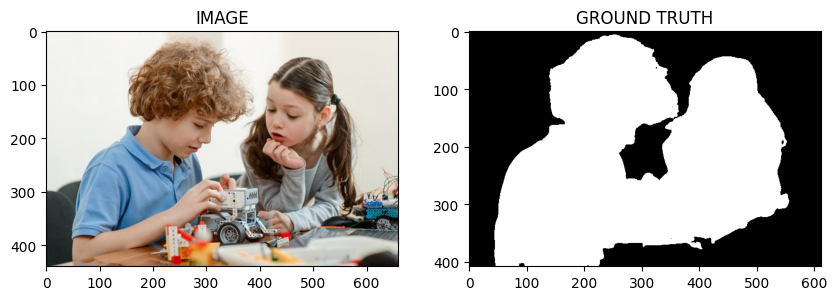

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df,valid_df = train_test_split(df,test_size=0.2 , random_state=42)

In [11]:
import albumentations as A

In [34]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], is_check_shapes=False)

def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)


In [35]:
from torch.utils.data import Dataset

In [53]:
def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # (h,w)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
        data = self.augmentations(image=image, mask=mask, is_check_shapes=False)  # Disable shape check
        image = data['image']
        mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # (h,w,c) -> (c,h,w)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)  # (h,w) -> (c,h,w)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask




In [54]:
trainset = SegmentationDataset(train_df , get_train_augs())
validset = SegmentationDataset(valid_df , get_valid_augs())


In [55]:
trainset = SegmentationDataset(train_df , get_train_augs())
validset = SegmentationDataset(valid_df , get_valid_augs())

In [56]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


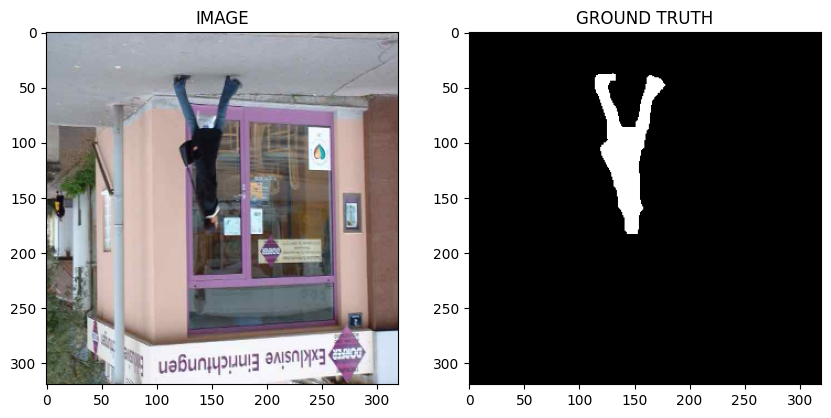

In [57]:
idx = 33

image, mask= trainset[idx]
helper.show_image(image, mask)

In [58]:
image.shape

torch.Size([3, 320, 320])

In [59]:
mask.shape

torch.Size([1, 320, 320])

In [60]:
from torch.utils.data import DataLoader

In [61]:
trainloader = DataLoader(trainset , batch_size =BATCH_SIZE , shuffle =True )
validloader = DataLoader(validset , batch_size =BATCH_SIZE  )

In [62]:
print(f"total no,of batches in trainloader: {len(trainloader)}")
print(f"total no,of batches in validloader: {len(validloader)}")

total no,of batches in trainloader: 15
total no,of batches in validloader: 4


In [63]:
for image , mask in trainloader:
  break
print (f'One batch image shape: {image.shape}')
print (f'One batch image shape: {mask.shape}')

One batch image shape: torch.Size([16, 3, 320, 320])
One batch image shape: torch.Size([16, 1, 320, 320])


In [64]:
! pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
from torch import nn 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [66]:
class SegmentationModel (nn.Module):

  def __init__(self):
    super (SegmentationModel , self).__init__()
    
    self.arc = smp.Unet(
        encoder_name= ENCODER ,
        encoder_weights=  WEIGHTS ,
        in_channels= 3 ,
        classes=  1 ,
        activation = None
    )
  def forward (self ,images ,masks = None):
    logits = self.arc(images)
    
    if masks != None :
      loss1 = DiceLoss(mode='binary')(logits , masks)
      loss2 = nn.BCEWithLogitsLoss()(logits , masks)
      return logits , loss1+loss2
    return logits

In [67]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

In [68]:
def train_fn (data_loader , model , optimizer):
  model.train()
  total_loss =0.0

  for images, masks in tqdm(data_loader) :

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits , loss = model(images ,masks)
    loss.backward()
    optimizer.step()

    total_loss +=loss.item()

    return total_loss / len(data_loader)

In [69]:
def eval_fn (data_loader , model ):

  model.eval()
  total_loss =0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader) :

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits , loss = model(images ,masks)

      total_loss +=loss.item()

  return total_loss / len(data_loader)

In [70]:
optimizer = torch.optim.Adam(model.parameters(),lr= LR)

In [71]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader , model , optimizer)
  valid_loss = eval_fn(validloader , model  )

  if valid_loss< best_valid_loss :
    torch.save(model.state_dict(), 'bestModel.pt')
    print ("SAVED")
    best_valid_loss = valid_loss
  print(f"Epoch : {i+1} train_loss :{train_loss} valid_loss :{valid_loss}" )

100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


SAVED
Epoch : 1 train_loss :0.09496014912923177 valid_loss :9.533727169036865


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch : 2 train_loss :0.08019819259643554 valid_loss :47.00221061706543


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


Epoch : 3 train_loss :0.06740612983703613 valid_loss :17.19372534751892


100%|██████████| 4/4 [00:00<00:00,  5.33it/s]


SAVED
Epoch : 4 train_loss :0.05527991056442261 valid_loss :3.023365616798401


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


SAVED
Epoch : 5 train_loss :0.04443541367848714 valid_loss :1.7704819738864899


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


Epoch : 6 train_loss :0.0427718718846639 valid_loss :4.939950942993164


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


Epoch : 7 train_loss :0.032703832785288496 valid_loss :6.46175217628479


100%|██████████| 4/4 [00:00<00:00,  5.30it/s]


Epoch : 8 train_loss :0.027375638484954834 valid_loss :3.925296664237976


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch : 9 train_loss :0.04111057917277018 valid_loss :3.079010009765625


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch : 10 train_loss :0.03729824622472127 valid_loss :5.053600907325745


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch : 11 train_loss :0.03299597104390462 valid_loss :3.038539409637451


100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


Epoch : 12 train_loss :0.026136072476704915 valid_loss :2.0985409915447235


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch : 13 train_loss :0.038469425837198895 valid_loss :2.370024085044861


100%|██████████| 4/4 [00:00<00:00,  5.34it/s]


Epoch : 14 train_loss :0.021270241340001425 valid_loss :2.0830976366996765


100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


SAVED
Epoch : 15 train_loss :0.02291881839434306 valid_loss :1.6346315145492554


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


SAVED
Epoch : 16 train_loss :0.025282438596089682 valid_loss :0.9740464389324188


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


SAVED
Epoch : 17 train_loss :0.021802051862080892 valid_loss :0.6424554511904716


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


SAVED
Epoch : 18 train_loss :0.029931525389353435 valid_loss :0.5816821157932281


100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


Epoch : 19 train_loss :0.02010658582051595 valid_loss :0.5948432460427284


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch : 20 train_loss :0.019773844877878824 valid_loss :0.608918696641922


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Epoch : 21 train_loss :0.021137126286824546 valid_loss :0.6963738054037094


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


Epoch : 22 train_loss :0.018113744258880616 valid_loss :0.7372550070285797


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch : 23 train_loss :0.01499828298886617 valid_loss :0.7351549118757248


100%|██████████| 4/4 [00:00<00:00,  5.35it/s]


Epoch : 24 train_loss :0.025901979207992552 valid_loss :0.6450750678777695


100%|██████████| 4/4 [00:00<00:00,  4.56it/s]

SAVED
Epoch : 25 train_loss :0.01994074781735738 valid_loss :0.5680035799741745
